In [1]:
!pip3 install cotk
!pip install livelossplot

Cloning into 'cotk'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 1789 (delta 5), reused 20 (delta 3), pack-reused 1748
Receiving objects: 100% (1789/1789), 4.71 MiB | 28.34 MiB/s, done.
Resolving deltas: 100% (1025/1025), done.
Processing ./cotk
     |████████████████████████████████| 1.5MB 4.8MB/s 
     |████████████████████████████████| 51kB 23.5MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-a7h7jigh/wheels/4c/55/4b/023e8c061ac8bf67267235c4b3c04ad6d8040ee62a61ab173d
  Stored in directory: /root/.cache/pip/wheels/41/c8/31/48ace4468e236e0e8435f30d33e43df48594e4d53e367cf061
  Stored in directory: /root/.cache/pip/wheels/d7/0e/6e/ad41ded2ca5d2fae0ae1b6dd6889eaa0ed14ed1c2a9f834197
Successfully built cotk nltk checksumdir
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
  Found existing installation: tqdm 4.28.1
 

In [2]:
  from cotk.dataloader import MSCOCO
  from pprint import pprint
  dataloader = MSCOCO("resources://MSCOCO_small") # "resources://MSCOCO_small" is a predefined resources name
  print("Vocab Size:", dataloader.vocab_size)
  print("First 10 tokens:",  dataloader.vocab_list[:10])
  print("Dataset is split into:", dataloader.key_name)
  data = dataloader.get_batch("train", [0]) # get the sample of id 0
  pprint(data, width=200)
  print(dataloader.convert_ids_to_tokens(data['sent'][0]))

INFO: name: MSCOCO_small
INFO: source: default
INFO: processor type: MSCOCO


100%|██████████| 1020154/1020154 [00:00<00:00, 1853831.54B/s]


INFO: resource cached at /root/.cotk_cache/9e4c0afe33d98fa249e472206a39e5553d739234d0a27e055044ae8880e314b1_unzip/mscoco
valid vocab list length = 2588
vocab list length = 12411
train set. invalid rate: 0.031716, unknown rate: 0.000000, max length before cut: 55, cut word rate: 0.000022
dev set. invalid rate: 0.034089, unknown rate: 0.000000, max length before cut: 46, cut word rate: 0.000000
test set. invalid rate: 0.031213, unknown rate: 0.000000, max length before cut: 27, cut word rate: 0.000000
Vocab Size: 2588
First 10 tokens: ['<pad>', '<unk>', '<go>', '<eos>', '.', 'a', 'A', 'on', 'of', 'in']
Dataset is split into: ['train', 'dev', 'test']
{'sent': array([[  2,   6,  67, 651, 549,  11,   5,  65,  89,  10, 115, 349,  83,
          4,   3]]),
 'sent_allvocabs': array([[  2,   6,  67, 651, 549,  11,   5,  65,  89,  10, 115, 349,  83,
          4,   3]]),
 'sent_length': array([15])}
['<go>', 'A', 'blue', 'lamp', 'post', 'with', 'a', 'sign', 'for', 'the', 'yellow', 'brick', 'road',

In [0]:
  import torch
  from torch import nn

  embedding_size = 20
  hidden_size = 20

  class LanguageModel(nn.Module):
      def __init__(self):
          super().__init__()
          self.embedding_layer = nn.Embedding(dataloader.vocab_size, embedding_size)
          self.rnn = nn.GRU(embedding_size, hidden_size, batch_first=True)
          self.output_layer = nn.Linear(hidden_size, dataloader.vocab_size)
          self.crossentropy = nn.CrossEntropyLoss()

      def forward(self, data):
          # data is the dict returned by ``dataloader.get_batch``
          sent = data['sent']
          sent_length = data['sent_length']
          # sent is a LongTensor whose shape is (batch_size, sent_length)
          # sent_length is a list whose size is (batch_size)

          incoming = self.embedding_layer(sent)
          # incoming: (batch_size, sent_length, embedding_size)
          incoming, _ = self.rnn(incoming)
          # incoming: (batch_size, sent_length, hidden_size)
          incoming = self.output_layer(incoming)
          # incoming: (batch_size, sent_length, dataloader.vocab_size)

          loss = []
          for i, length in enumerate(sent_length):
              if length > 1:
                  loss.append(self.crossentropy(incoming[i, :length-1], sent[i, 1:length]))
                  # every time step predict next token

          data["gen_log_prob"] = nn.LogSoftmax(dim=-1)(incoming)

          if len(loss) > 0:
             return torch.stack(loss).mean()
          else:
              return 0


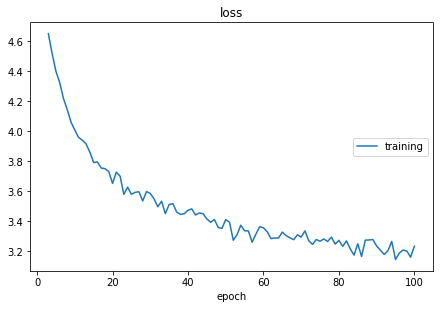

loss:
training   (min:    3.147, max:    6.560, cur:    3.235)
epoch 100/100


In [4]:
    from livelossplot import PlotLosses
    import numpy as np

    net = LanguageModel()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)
    epoch_num = 100
    batch_size = 16
    plot = PlotLosses()

    for j in range(epoch_num):
        loss_arr = []
        for i, data in enumerate(dataloader.get_batches("train", batch_size)):
            # convert numpy to torch.LongTensor
            data['sent'] = torch.LongTensor(data['sent'])
            net.zero_grad()
            loss = net(data)
            loss_arr.append(loss.tolist())
            loss.backward()
            optimizer.step()
            if i >= 40:
                break # break for shorten time of an epoch
        plot.update({"loss": np.mean(loss_arr)})
        plot.draw()
        print("epoch %d/%d" % (j+1, epoch_num))

In [5]:
metric = dataloader.get_teacher_forcing_metric(gen_log_prob_key="gen_log_prob")
for i, data in enumerate(dataloader.get_batches("test", batch_size)):
    # convert numpy to torch.LongTensor
    data['sent'] = torch.LongTensor(data['sent'])
    with torch.no_grad():
        net(data)
    assert "gen_log_prob" in data
    metric.forward(data)
pprint(metric.close(), width=150)

test set restart, 78 batches and 2 left
{'perplexity': 33.99345315581511,
 'perplexity hashvalue': b'O\x10\x1c)\x86\xf1\xfe\x10\xce\x1d!\x97\xc3\x08m6Y\xae\xc3\xe6I_8\x1dg\xf0\x0bM\xbb@\xa58'}


In [6]:
metric = dataloader.get_inference_metric(gen_key="gen")
generate_sample_num = 1
max_sent_length = 20

for i in range(generate_sample_num):
    # convert numpy to torch.LongTensor
    data['sent'] = torch.LongTensor([[dataloader.go_id] for _ in range(batch_size)])
    data['sent_length'] = np.array([1 for _ in range(batch_size)])
    for j in range(max_sent_length):
        with torch.no_grad():
            net(data)
            generated_token = torch.multinomial(data['gen_log_prob'].exp()[:, -1], 1)
        data['sent'] = torch.cat([data['sent'], generated_token], dim=-1)

    metric.forward({"gen": data['sent'][:, 1:].tolist()})
pprint(metric.close(), width=250)

100%|██████████| 1000/1000 [00:00<00:00, 1153.17it/s]

{'bw-bleu': 0.054939232761090494,
 'fw-bleu': 0.2643063370185712,
 'fw-bw-bleu': 0.09096938998850655,
 'fw-bw-bleu hashvalue': b'0\x18\xdc1\x7f\x82\xb6\x01?\x01\x1c\x1f\x8c\xcd\x90\xc5\xaf\xfe\xd7\x10\xb7\xd7\xd0jr5\xcfE\\#5B',
 'gen': [['A', 'black', 'fire', 'hydrant', 'with', 'broccoli', 'on', 'a', 'plate', '.'],
         ['A', 'small', 'cat', 'that', 'drinking', 'are', 'sitting', 'from', 'a', 'screen', '.'],
         ['This', 'was', 'hydrant', 'at', 'a', 'kitchen', 'by', 'a', 'meal', '.'],
         ['A', 'bath', 'room', 'with', 'a', 'bicycle', 'are', 'antique', '<unk>', ',', 'sink', 'and', 'patterned', 'photograph', 'and', 'fork', 'look', 'on', 'the', 'bed'],
         ['Large', 'yellow', 'kitchen', 'with', 'one', 'and', '<unk>', 'neat', ',', 'kite', '.'],
         ['A', 'young', 'girl', 'are', 'kneeling', 'a', 'tennis', 'match', 'during', 'tennis', 'of', 'her', 'bat', '.'],
         ['A', 'zebra', 'leaned', 'across', 'a', 'city', 'street', '.'],
         ['A', 'tennis', 'player', 'l

In [7]:
metric = dataloader.get_teacher_forcing_metric(gen_log_prob_key="gen_log_prob")
for i, data in enumerate(dataloader.get_batches("test", batch_size)):
    # convert numpy to torch.LongTensor
    data['sent'] = torch.LongTensor(data['sent'])
    with torch.no_grad():
        net(data)
    assert "gen_log_prob" in data
    metric.forward(data)
    if i >= 15: #ignore the following batches
        break
pprint(metric.close(), width=150)

test set restart, 78 batches and 2 left
{'perplexity': 31.5929983966103, 'perplexity hashvalue': b"\x0c\xfd9r\xc7\x8b_\xf5\xf7\xf90\xd1v\x7f\xd8Ua\xc8g\xdc\xd3MV\xeeH\xe0\x86\xed@'\x91\x91"}
